# Pipeline for analysing OCs based on Gaia EDR3 Distances

#### Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3
#### Bailer-Jones, C. A. L.; Rybizki, J.; Fouesneau, M. and 2 more

## 1 - Libraries

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import astropy
import astropy.stats as ap
import matplotlib.pyplot as plt
import pyvo as vo

from astropy import units
from astropy.table import Table
from astropy.coordinates import SkyCoord
from IPython.display import display, HTML

## 2 - Constants

In [2]:
svc_url = 'https://dc.zah.uni-heidelberg.de/__system__/tap/run/tap'

query = f'SELECT \
   lite.source_id \
   ,lite.ra \
   ,lite.dec \
   ,lite.pmra \
   ,lite.pmdec \
   ,lite.parallax \
   ,main.r_med_geo \
   ,main.r_med_photogeo \
   ,lite.phot_g_mean_mag \
FROM \
   gaia.edr3lite lite \
   INNER JOIN gedr3dist.main main ON lite.source_id = main.source_id \
WHERE 1=1 \
   AND lite.ruwe < 1.4 '

# Our estimates are quantiles of a posterior probability distribution, so they transform invariably
# and can therefore also be used directly in the distance modulus (5log10(r)-5).

## 2 - Catalogue access

In [3]:
def query_data(ra, de, rad, mag_min, mag_max, pmra_min, pmra_max, pmde_min, pmde_max, dist_min, dist_max):
    qry = query
    de_hi = de + rad + 0.0001
    de_lo = de - rad - 0.0001
    #the resulting query is slow using the if below
    #if dist_lim: qry = qry + f' AND main.r_med_geo < {dist_lim}'
    qry = qry + f' AND lite.phot_g_mean_mag > {mag_min:4.2f}'
    qry = qry + f' AND lite.phot_g_mean_mag < {mag_max:4.2f}'
    qry = qry + f' AND lite.dec < {de_hi:8.6f}'
    qry = qry + f' AND lite.dec > {de_lo:8.6f}'
    qry = qry + f' AND DISTANCE(lite.ra, lite.dec, {ra:8.6f}, {de:+8.6f}) < {rad:8.6f}'
    tap_service = vo.dal.TAPService(svc_url)
    #resultset = tap_service.search(qry, maxrec=160000)
    resultset = tap_service.run_async(qry, maxrec=160000) # tap_service.hardlimit = 16000000
    df = resultset.to_table().to_pandas()
    df = df.set_index('source_id')
    df = df[df['pmra'] > pmra_min]
    df = df[df['pmra'] < pmra_max]
    df = df[df['pmdec'] > pmde_min]
    df = df[df['pmdec'] < pmde_max]
    df['dist_mod'] = 5 * np.log10(df['r_med_geo']) - 5  # r_med_photogeo
    df = df[df['r_med_geo'] > dist_min]
    df = df[df['r_med_geo'] < dist_max]
    df = df.sort_values(by='ra')
    #display(df.describe())
    return df

# convert sexagesimal to decimal coordinates
def convert(_ra, _dec, diam):
    uns = [['h','m','s'],['d','m','s']]
    comps = list(zip(_ra.split(' '),uns[0]))
    ra = ''.join([item for sublist in comps for item in sublist])
    comps = list(zip(_dec.split(' '),uns[1]))
    dec = ''.join([item for sublist in comps for item in sublist])
    c = SkyCoord(ra, dec, frame='icrs')
    return c.ra.value, c.dec.value, diam / 120

## 3 - VPD scatter plot and 2D Histogram (returning PMs for the bin with highest count)

In [4]:
# Build a VPD (Vector Proper Motion Diagram) scatter plot
def plot_VPD(data, title, pmra_min, pmra_max, pmde_min, pmde_max):
    pmras = data['pmra']
    pmdes = data['pmdec']
    plt.title(title)
    plt.xlim(pmra_min, pmra_max)
    plt.ylim(pmde_min, pmde_max)
    plt.xlabel('pmRA (mas/yr)')
    plt.ylabel('pmDe (mas/yr)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(pmras, pmdes, s=3, color='black')

# Build 2D histogram for proper motions and returns average PMs for the bin with the highest count
def plot_pm_hist(data, pmra_min, pmra_max, pmde_min, pmde_max, num_bins = 15):
    xs = data['pmra']
    ys = data['pmdec']
    _range = [[pmra_min, pmra_max], [pmde_min, pmde_max]]
    counts, xedges, yedges = np.histogram2d(xs, ys, bins = num_bins, range = _range)
    x_ind, y_ind = np.unravel_index(np.argmax(counts), counts.shape)
    est_pmRA = (xedges[x_ind] + xedges[x_ind+1]) / 2
    est_pmDe = (yedges[y_ind] + yedges[y_ind+1]) / 2
    plt.imshow(counts.T, origin = 'lower')
    plt.xlabel('pmRA bin index')
    plt.ylabel('pmDE bin index')
    plt.plot(x_ind, y_ind, 'or')
    return est_pmRA, est_pmDe

# Build G mag X Distance Modulus scatter plot
def plot_mag_par(data):
    dists = data['r_med_geo']
    gmags = data['phot_g_mean_mag']
    plt.xlabel('G (mag)')
    plt.ylabel('Dist. (Pc)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(gmags, dists, s=3, color='black')
    
def constrain_by_pms(data, est_pmra, est_pmde, limit = 1.5):
    def filter_pms(pmra, pmde):
        return (abs(est_pmra - pmra) < limit) and (abs(est_pmde - pmde) < limit)
    filter_fn = lambda x: filter_pms(x['pmra'], x['pmdec'])
    return data[data.apply(filter_fn, axis = 1)]

# plot estimates and both graphics side-by-side
def plot_all(data, cl_name, pmra_min, pmra_max, pmde_min, pmde_max, num_bins, limit):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(131)
    plot_VPD(data, cl_name, pmra_min, pmra_max, pmde_min, pmde_max)
    plt.subplot(132)
    est_pmra, est_pmde = plot_pm_hist(data, pmra_min, pmra_max, pmde_min, pmde_max, num_bins)
    plt.subplot(133)
    pm_constrained_data = constrain_by_pms(data, est_pmra, est_pmde, limit)
    plot_mag_par(pm_constrained_data)
    plt.tight_layout()
    return pm_constrained_data

## 4 - Do the calculations

In [5]:
def calc_vals(pm_constrained_data, dist_min, dist_max):
    pm_constrained_data    = pm_constrained_data[pm_constrained_data['r_med_geo'] > dist_min]
    final_constrained_data = pm_constrained_data[pm_constrained_data['r_med_geo'] < dist_max]
    dsts = final_constrained_data['r_med_geo']
    mods = final_constrained_data['dist_mod']
    pars = final_constrained_data['parallax']
    pmra = final_constrained_data['pmra']
    pmde = final_constrained_data['pmdec']
    gmag = final_constrained_data['phot_g_mean_mag']
    dist, e_dist = np.median(dsts),  ap.median_absolute_deviation(dsts)
    mod,  e_mod  = np.median(mods),  ap.median_absolute_deviation(mods)
    par,  e_par  = np.median(pars),  ap.median_absolute_deviation(pars)
    pmra, e_pmra = np.median(pmra),  ap.median_absolute_deviation(pmra)
    pmde, e_pmde = np.median(pmde),  ap.median_absolute_deviation(pmde)
    gmin, gmax   = np.min(gmag),     np.max(gmag)
    n = len(dsts)
    return (dist, e_dist, mod, e_mod, par, e_par, pmra, e_pmra, pmde, e_pmde, gmin, gmax, n)

def check_reality(par, epra, epde):
    """ see arXiv:1911.07075 """
    err = math.sqrt(epra * epra + epde * epde)
    is_real = err < 1 if par < 1 else err < (5 * math.sqrt(2) * (par/4.74))
    return 'y' if is_real else 'n'

def print_estimates(name, coords, dia, derived_vals):
    coo = coords.replace(' ','').replace('.','')
    dst, e_dst, mod, e_mod, par, e_par, pra, e_pra, pde, e_pde, gmin, gmax, n = derived_vals
    is_real = check_reality(par, e_pra, e_pde)
    diaf   = f'{dia:6.1f}'
    distf  = f'{dst:6.1f}'
    edistf = f'{e_dst:6.1f}'
    modf   = f'{mod:7.3f}'
    emodf  = f'{e_mod:4.3f}'
    parf   = f'{par:7.3f}'
    eparf  = f'{e_par:4.3f}'
    pmraf  = f'{pra:+7.3f}'
    epmraf = f'{e_pra:4.3f}'
    pmdef  = f'{pde:+7.3f}'
    epmdef = f'{e_pde:4.3f}'
    gmagf  = f'{gmin:5.2f}..{gmax:5.2f}'
    estimates =  f'{name:<10} '
    estimates += f'{is_real:<2}'
    estimates += f'{coo:<15}'
    estimates += f'{diaf:>5} '
    estimates += f'{distf:>7} {edistf:>6} '
    estimates += f'{modf:>6} {emodf:>5}'
    estimates += f'{parf:>6} {eparf:>5} '
    estimates += f'{pmraf:>8}{epmraf:>6} '
    estimates += f'{pmdef:>8}{epmdef:>6} '
    estimates += f'{n:>5} '
    estimates += f'{gmagf:>12} '
    print(estimates)

def coord_split(coords, diam):
    has_minus = '-' in coords
    ra_sexa, de_sexa = coords.split('-') if has_minus else coords.split('+')
    de_sexa = '-' + de_sexa if has_minus else de_sexa
    return convert(ra_sexa.strip(), de_sexa.strip(), diam)
    
def range_split(range):
    _min, _max = range.split('..')
    return float(_min), float(_max)

def process(name, coords, diam, mag_range, pmra_range, pmde_range, dist_range, num_bins, limit):
    ra_deg, de_deg, rad_deg = coord_split(coords, diam)
    mag_min,  mag_max  = range_split(mag_range)
    pmra_min, pmra_max = range_split(pmra_range)
    pmde_min, pmde_max = range_split(pmde_range)
    dist_min, dist_max = range_split(dist_range)
    df = query_data(ra_deg, de_deg, rad_deg, mag_min, mag_max, pmra_min, pmra_max, pmde_min, pmde_max, dist_min, dist_max)
    pm_cons_data = plot_all(df, name, pmra_min, pmra_max, pmde_min, pmde_max, num_bins, limit)
    derived_vals = calc_vals(pm_cons_data, dist_min, dist_max)
    cl_data = (name, ra_deg, de_deg, rad_deg, derived_vals)
    print_estimates(name, coords, diam, derived_vals)
    return cl_data

## 5 - Run

OPD 54         y 0542540+133942   20.0  1038.4   21.5  10.082 0.045  0.928 0.018   +0.713 0.080   -3.571 0.047    31 10.14..16.70 


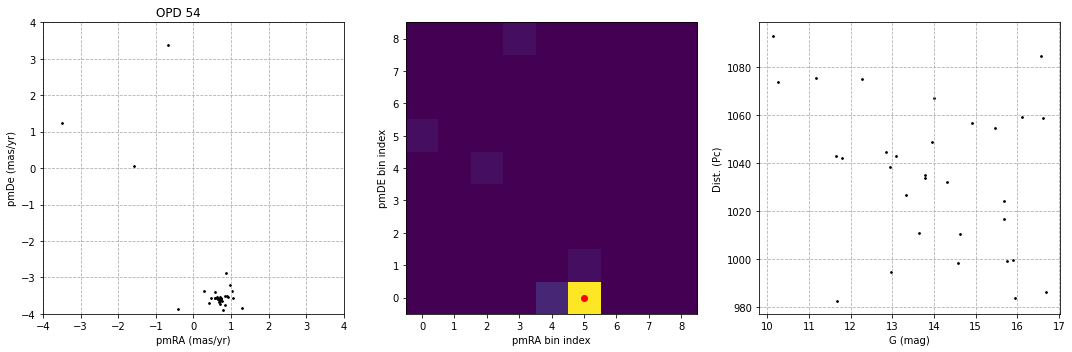

In [70]:
#process(name, coords, diam_arcm, mag_rng, pmra_rng, pmde_rng, dist_rng, num_bins, hist_pm_lim)
#dd = process('Ale 62', '18 56 06.2 +21 35 49', 36.0, '0..19', '-10..10', '-10..10', '0..1000', 15, 1.5)

#dd = process('Eps Cap', '21 37 04.6 -19 27 57', 160.0, '0..18', '0..20', '-10..10', '220..340', 10, 3)
#dd = process('Minni 330', '18 55 38 -29 59 24', 10.0, '0..18.5', '-10..10', '-10..10', '1000..20000', 15, 1.5)

dd = process('OPD 54        ', '05 42 54.0 +13 39 42', 20, '0..17', '-4..4', '-4..4', '950..1100', 9, 1)

## 6 - Chart and RDP scatter plot (constrained by the estimated values)

AttributeError: 'Float64Index' object has no attribute 'to_tuples'

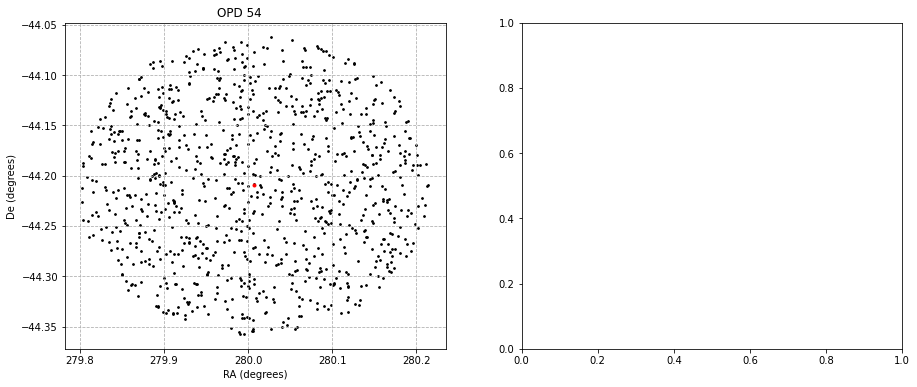

In [7]:
def plot_chart(data, ra_deg, de_deg, title):
    xs, ys = data['ra'], data['dec']
    plt.title(title)
    plt.xlabel('RA (degrees)')
    plt.ylabel('De (degrees)')
    plt.grid(True, linestyle='dashed')
    plt.scatter(xs, ys, s=3, color='black')
    plt.plot([ra_deg], [de_deg], marker='o', markersize=3, color="red")

def plot_RDP(data, num_bins, title = None):
    def ring_area(inner_rad, outer_rad):
        return pi * (outer_rad**2 - inner_rad**2)
    bins = data['_r'].value_counts(num_bins).sort_index()
    intervals = bins.index.to_tuples()
    midpoints = [i.mid for i in bins.index]
    counts = bins.values
    zipped = tuple(zip(intervals, midpoints, counts))
    densities = [count / ring_area(inner*60, outer*60) for ((inner, outer), midpoint, count) in zipped]
    log_dens = [np.log10(dens) if dens > 0 else 0 for dens in densities]
    plt.grid(True, linestyle='dashed')
    plt.title(title)
    plt.xlabel('Radius (degrees)')
    plt.xticks([i for i,j in intervals], rotation='vertical')
    plt.ylabel('Logarithm of Star Density (stars/arcmin^2)')
    plt.scatter(midpoints, log_dens, s=6, color='black')

def plot_chart_and_rdp(data, ra_deg, de_deg, num_bins, cl_name):
    fig = plt.figure(figsize=(15,6))
    plt.subplot(121)
    plot_chart(data, ra_deg, de_deg, cl_name)
    plt.subplot(122)
    plot_RDP(data, num_bins, cl_name)
    plt.tight_layout()

def calc_rad(ra_center, de_center, row):
    _ra = row['ra']
    _de = row['dec']
    cl_center = SkyCoord(ra=ra_center*units.degree, dec=de_center*units.degree, frame='icrs')
    st_coord  = SkyCoord(ra=_ra*units.degree, dec=_de*units.degree, frame='icrs')
    return cl_center.separation(st_coord).degree

def do_step_6(cl_data, rad_mul = 2, num_bins = 25):
    cl_name, ra_deg, de_deg, rad_deg, derived_vals = cl_data
    dst, e_dst, mod, e_mod, par, e_par, pra, e_pra, pde, e_pde, gmin, gmax, n = derived_vals
    rad = rad_mul * rad_deg
    mul = 2
    pmra_min = pra - (1 if e_pra < 0.5 else mul * e_pra)
    pmra_max = pra + (1 if e_pra < 0.5 else mul * e_pra) 
    pmde_min = pde - (1 if e_pde < 0.5 else mul * e_pde)
    pmde_max = pde + (1 if e_pde < 0.5 else mul * e_pde)
    dist_min = dst - (200 if e_dst < 100 else mul * e_dst) 
    dist_max = dst + (200 if e_dst < 100 else mul * e_dst) 
    df2 = query_data(ra_deg, de_deg, rad, gmin, gmax, pmra_min, pmra_max, pmde_min, pmde_max, dist_min, dist_max)
    df2['_r'] = df2.apply (lambda row: calc_rad(ra_deg, de_deg, row), axis=1)
    plot_chart_and_rdp(df2, ra_deg, de_deg, num_bins, cl_name)

do_step_6(dd)